In [1]:
# Author: Samantha Tetef
# Created: 8.26.20
# Title: XANESML

# This notebook analyzes hundreds of sulfur compounds K edge XANES spectra using various machine learning techniques

In [2]:
import warnings
warnings.filterwarnings("ignore")

from utils import *

## to reload utils:
# from importlib import reload
# import utils as utils
# utils = reload(utils)
# from utils import *

from random import randint  

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from keras.models import Model, Sequential
from keras import backend as K
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
from keras.activations import*
from keras.regularizers import l2
from keras.models import load_model

from sklearn import neighbors
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, NMF
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
     return false;
}

<IPython.core.display.Javascript object>

# Reading in spectra

Reading in compound names from lists (text files)

In [4]:
# setting up directory (this is unique to my own local machine)
ROOTDIR = os.getcwd()
TYPEdir = "Categories/"

### Creating dictionary list of compound categories

Spectrum must have been preprocessed using the SpectraFromDat python script

In [5]:
Data = get_XANES(Types, TYPEdir)
N = len(Data)
NAMES = get_Property(Data, 'name')

In [6]:
# temporary fix for 2-2-Hydroxyphenyl_benzothiazole
for ele in Data:
    if ele['name'] == "2-2-Hydroxyphenyl_benzothiazole":
        x, y = ele['XANES']
        y = y*10
        ele['XANES'] = [x, y]

# XANES

In [7]:
XANES = np.array(get_Property(Data, 'XANES'))
NAMES = get_Property(Data, 'name')
XANESenergy = XANES[0,0,:]
X = XANES[:,1,:]

SCALING_FACTOR = np.max(X)
X = X/SCALING_FACTOR

In [8]:
test_list = get_text_in_file('Categories/TEST.txt').split('\n')
# test_list = ['2-Fluorocyclohexane-1-thiol']

TESTData = get_TEST_Data(test_list, directory='XANES')
TEST_NAMES = get_Property(TESTData, 'Name')

TEST_XANES_tuple = np.array(get_Property(TESTData, 'Spectra'))
TEST_XANES = TEST_XANES_tuple[:,1,:]

TEST_XANES = TEST_XANES/SCALING_FACTOR

In [9]:
def adjust_trans(trans, spectrum):
    xtemp, y = trans.copy()
    xtemp += 53.3
    
    bool_arr = xtemp < 2495
    x1 = xtemp[bool_arr]
    y1 = y[bool_arr]
    
    y1 /= np.max(y1)
    y1 *= np.max(spectrum)
    return x1, y1

In [10]:
# name = '2-Fluorocyclohexane-1-thiol'
# index = TEST_NAMES.index(name)

# trans1 = TESTData[index]['Transitions']
# x1 = TEST_XANES[index]

# trans_cut1 = adjust_trans(trans1, x1)
# emp = np.zeros(len(trans_cut1[0]), dtype=bool)
# emp[-1] = 1

# plot_spectrum_and_trans(trans_cut1, [XANESenergy, x1], f'{name}', figsize=(8,6),
#                         label='XANES', ylab=False, emp=emp)

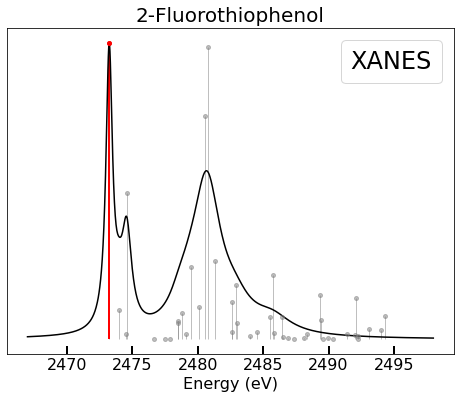

In [11]:
name = '2-Fluorothiophenol'
index = NAMES.index(name)

x2 = get_Spectrum(Data, name, mode='XANES')[1]/SCALING_FACTOR
trans2 = Data[index]['Transitions']

trans_cut2 = adjust_trans(trans2, x2)
emp = np.zeros(len(trans_cut2[0]), dtype=bool)
emp[-1] = 1
# emp[-4] = 1

plot_spectrum_and_trans(trans_cut2, [XANESenergy, x2],
                        f'{name}', figsize=(8,6),
                        label='XANES', ylab=False, emp=emp)

In [12]:
def get_x(name):
    x = get_Spectrum(Data, name, mode='XANES')[1]
    x = x/SCALING_FACTOR
    return x

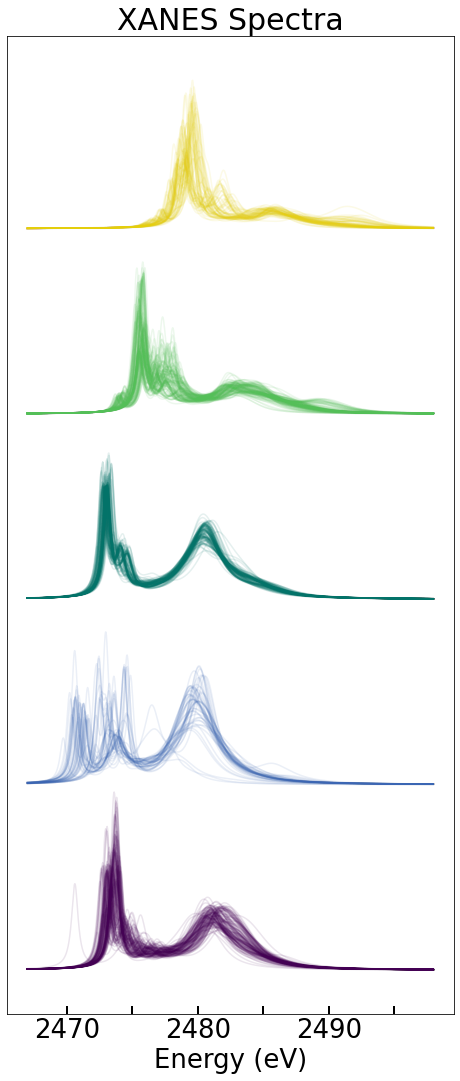

In [13]:
Spagetti_plot(Data, XANESenergy, SCALING_FACTOR, mode='XANES')

In [14]:
# # ------------------------------------------------------------
# # ALIGNING WHITIELINES!
# # ------------------------------------------------------------
# temp_X = X.copy()

# def rebin(target_peak_energy, XANESenergy, x, max_E=-1):
    
#     n = len(XANESenergy)
#     x_new = np.zeros(n)
    
#     if max_E != -1:
#         max_i = index_from_array(XANESenergy, max_E)
#     else:
#         max_i = -1
    
#     peak_index = np.argmax(x[:max_i])   
#     target_peak_index = index_from_array(XANESenergy, target_peak_energy)
    
#     shift = peak_index - target_peak_index
    
#     if shift > 0:
#         for i in range(shift, len(XANESenergy)):
#             x_new[i - shift] = x[i]
#     else:       
#         shift = np.abs(shift)
#         for i in range(len(XANESenergy) - shift):
#             x_new[i + shift] = x[i]
    
#     return x_new
    
# for i in range(len(X)):
#     if Data[i]["Type"] == 2:
#         temp_X[i,:] = rebin(2475, XANESenergy, X[i,:], max_E = 2472)
#     else:
#         temp_X[i,:] = rebin(2475, XANESenergy, X[i,:])

# Spagetti_plot(Data, X=temp_X)
# X = temp_X.copy()

In [15]:
# names = ['Methionine', 'Cysteine']
# Spectra = [get_x(name) for name in names]
# stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(12,8), leg=1)

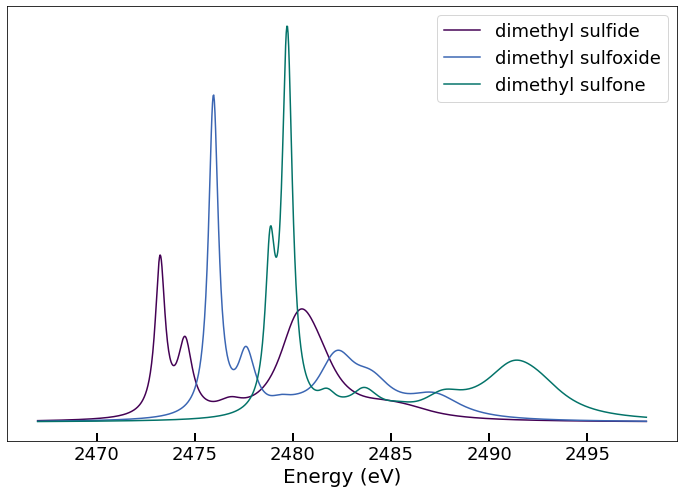

In [16]:
names = ['Dimethyl_Sulfide', 'Dimethyl_Sulfoxide', 'Dimethyl_sulfone']
Spectra = [get_x(name) for name in names]
names = ['dimethyl sulfide', 'dimethyl sulfoxide', 'dimethyl sulfone']
stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(12,8), leg=1)

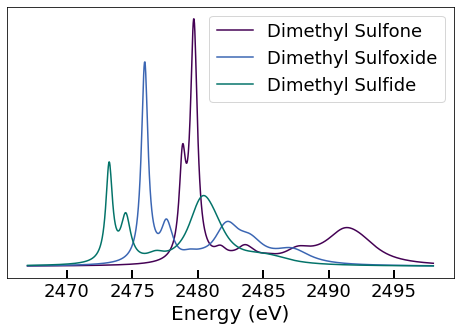

In [17]:
names = ['Dimethyl_sulfone','Dimethyl_Sulfoxide', 'Dimethyl_Sulfide']
Spectra = [get_x(name) for name in names]
names = ['Dimethyl Sulfone','Dimethyl Sulfoxide', 'Dimethyl Sulfide']
stack_plot(XANESenergy, Spectra, names, '', space=0, figsize=(8,5), leg=1)

=========================================================================================================================

# Data analysis

# Artificial Neural Network Section

### Network hyperparameters

In [18]:
# hidden layer dimensions
intermediate_dim_1 = 1024 

batch_size = 50
epochs = 30

train_size = 700

### Generating Labels

In [19]:
# PROPERTY = 'Type'
PROPERTY = 'oxy'
# PROPERTY = 'category'

Y = get_Property(Data, PROPERTY) #labels are one hot encoded

## Data pre-processing and shuffling

In [20]:
# random shuffle of data
Xshuffle, Yshuffle = shuffle_xy(X, Y)

x_train = Xshuffle[:train_size]
y_train = Yshuffle[:train_size]

x_test = Xshuffle[train_size:]
y_test = Yshuffle[train_size:]

n_y = y_train.shape[1]
n_x = x_train.shape[1]

# Generating new ANN Model

In [21]:
# # input
# Xin = Input(shape=(n_x,), name='spectra_input')
# # model layers
# lay = Dense(intermediate_dim_1, activation='relu', kernel_regularizer='l2',
#             name='hidden_layer_1')(Xin)
# lay = Dropout(0.05)(lay)
# # lay = Dense(intermediate_dim_2, activation='relu', name='layer_2')(lay)
# nn_out = Dense(n_y, activation='softmax', name='classifier')(lay)

# ANN = Model(Xin, nn_out)

# ANN.compile(optimizer='adam', loss='binary_crossentropy')
# ANN.summary()

# ANN.fit(x_train, y_train, 
#          shuffle=True, batch_size=batch_size, epochs=epochs,
#          validation_data=(x_test, y_test))
# ANN.save(f'models/XANES_ANN_{PROPERTY}.h5')

# Loading pre-trained model

In [22]:
# PROPERTY = 'Type'
# PROPERTY = 'oxy'
PROPERTY = 'category'
ANN = load_model(f'models/XANES_ANN_{PROPERTY}.h5', compile=False)

# Prediction Results

In [23]:
if PROPERTY == 'oxy':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 3))
    for i,o in enumerate(TEST_OXY):
        one_hot_encoded_label[i,o-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)
if PROPERTY == 'Type':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 5))
    for i,t in enumerate(TEST_TYPE):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)
if PROPERTY == 'category':
    one_hot_encoded_label = np.zeros((len(TEST_XANES), 10))
    for i,t in enumerate(TEST_CAT):
        one_hot_encoded_label[i,t-1] = 1
    true, pred = get_prediction(ANN, TEST_XANES, one_hot_encoded_label)

In [24]:
totalTestAccuracy = sum(1 for i in range(len(pred)) if pred[i] == true[i])/len(pred)
print(f"Total accuracy on test data: {totalTestAccuracy} of {len(pred)} compounds")

Total accuracy on test data: 0.6923076923076923 of 52 compounds


### Confusion Matrix

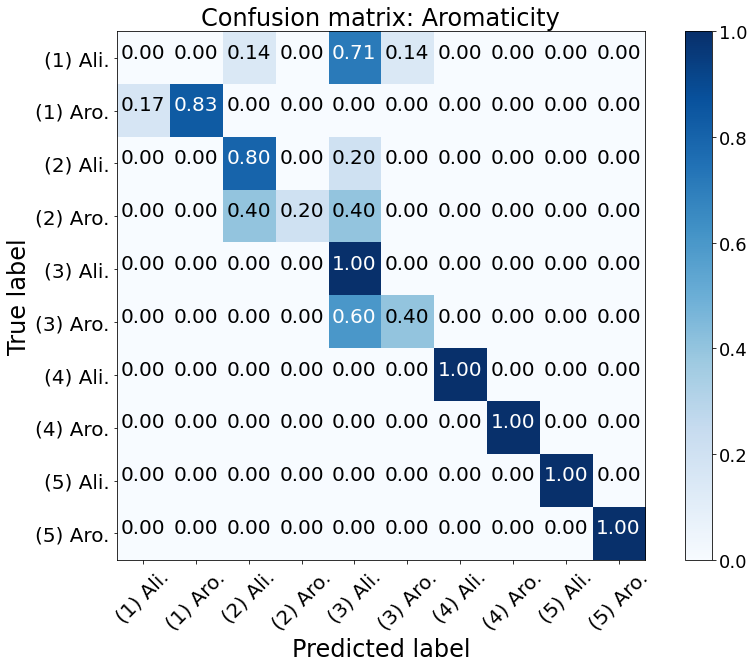

In [25]:
if PROPERTY == 'Type':    
    make_confusion_matrix(true, pred, Types, PROPERTY)
if PROPERTY == 'oxy':
    make_confusion_matrix(true, pred, Oxys, PROPERTY)
if PROPERTY == 'category':
    make_confusion_matrix(true, pred, Categories, PROPERTY)

=========================================================================================================================

# VAE Categorization

# Generating new VAE model

In [26]:
# class Sampling(tf.keras.layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [27]:
# # hidden layer dimensions
# intermediate_dim_1 = 512
# intermediate_dim_2 = 246
# latent_dim = 2

# batch_size = 50
# epochs = 120

# dropout = 0.15

# activation='relu'

# # input
# Xin = Input(shape=(n_x,), name='spectra_input')

# # encoder
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(Xin)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_2, activation=activation, kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# # z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
# z = Sampling()([z_mean, z_log_var])

# # encoder
# encoder = Model(Xin, [z_mean, z_log_var, z], name='encoder')

# # decoder
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(latent_inputs)
# x = Dropout(dropout)(x)
# x = Dense(intermediate_dim_1, activation=activation, kernel_regularizer='l2')(x)
# x = Dropout(dropout)(x)
# outputs = Dense(n_x, activation='sigmoid')(x)

# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# Output = decoder(encoder(Xin)[2])
# vae = Model(Xin, Output, name='VAE')

# reconstruction_loss = n_x * binary_crossentropy(Xin, Output)
# kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
# kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
# vae_loss = K.mean(reconstruction_loss + kl_loss)

# vae.add_loss(vae_loss)

# vae.compile(optimizer='adam')

# history = vae.fit(x_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, None))

In [28]:
# vae.save('models/XANES_VAE', save_format="tf")
# encoder.save('models/XANES_encoder', save_format="tf")
# decoder.save('models/XANES_decoder', save_format="tf")

In [29]:
# # copy-pasted from XESML
# xes_loss = np.array([587.4163208007812, 289.7535095214844, 235.5487518310547, 219.5084686279297, 212.82444763183594, 209.2156219482422, 206.50743103027344, 205.59414672851562, 203.83714294433594, 202.40573120117188, 201.30972290039062, 200.91807556152344, 200.20797729492188, 198.9169464111328, 198.54226684570312, 197.57217407226562, 196.9044647216797, 196.51730346679688, 196.10800170898438, 195.96981811523438, 195.58645629882812, 195.17782592773438, 194.9303741455078, 194.8458251953125, 194.57009887695312, 194.4072723388672, 194.02676391601562, 193.9930419921875, 193.73245239257812, 193.5954132080078, 193.58607482910156, 193.28297424316406, 193.13406372070312, 192.95486450195312, 192.94143676757812, 192.711669921875, 192.64797973632812, 192.4241180419922, 192.54666137695312, 192.45594787597656, 192.3738250732422, 192.21609497070312, 192.0460205078125, 192.06813049316406, 191.87437438964844, 191.6284637451172, 191.53512573242188, 191.32748413085938, 191.18458557128906, 190.96182250976562, 190.77999877929688, 190.6433563232422, 190.4116973876953, 190.34751892089844, 190.0126953125, 189.8665771484375, 189.70053100585938, 189.70518493652344, 189.522216796875, 189.39083862304688, 189.296875, 189.22242736816406, 189.1047821044922, 189.0765380859375, 189.00808715820312, 189.04383850097656, 188.93336486816406, 189.00196838378906, 188.86767578125, 188.87838745117188, 188.86474609375, 188.677978515625, 188.83889770507812, 188.8516845703125, 188.75643920898438, 188.76602172851562, 188.57406616210938, 188.64712524414062, 188.70254516601562, 188.6536865234375, 188.68826293945312, 188.71859741210938, 188.72817993164062, 188.68235778808594, 188.6370391845703, 188.59071350097656, 188.51248168945312, 188.56654357910156, 188.60508728027344, 188.49110412597656, 188.40243530273438, 188.39938354492188, 188.45364379882812, 188.47984313964844, 188.5147247314453, 188.462646484375, 188.4756622314453, 188.45631408691406, 188.4014892578125, 188.51417541503906, 188.3063201904297, 188.3390655517578, 188.34658813476562, 188.384765625, 188.46426391601562, 188.37205505371094, 188.35264587402344, 188.2953338623047, 188.3475799560547, 188.3788604736328, 188.34207153320312, 188.2994842529297, 188.3293914794922, 188.30763244628906, 188.33200073242188, 188.2676544189453, 188.20565795898438, 188.30099487304688, 188.3021240234375, 188.3164825439453])
# xes_val_loss = np.array([346.8323059082031, 246.225341796875, 224.42642211914062, 215.96360778808594, 211.27345275878906, 208.4990692138672, 206.29312133789062, 204.4748077392578, 204.44627380371094, 203.5107879638672, 201.87852478027344, 202.4175262451172, 202.30313110351562, 200.8977508544922, 199.2266082763672, 198.39215087890625, 197.66590881347656, 197.93704223632812, 198.3144989013672, 197.57135009765625, 196.82815551757812, 197.28977966308594, 196.3883056640625, 196.32765197753906, 195.81593322753906, 196.8367156982422, 195.54415893554688, 195.62374877929688, 195.3625030517578, 196.1329803466797, 194.63760375976562, 195.19976806640625, 195.12294006347656, 194.79791259765625, 194.91551208496094, 194.45570373535156, 194.64332580566406, 194.26771545410156, 194.2083740234375, 194.47360229492188, 194.08761596679688, 193.97515869140625, 194.1699981689453, 193.87933349609375, 194.17970275878906, 193.85716247558594, 193.21180725097656, 193.21832275390625, 193.2945556640625, 193.23414611816406, 192.95335388183594, 193.10400390625, 192.85543823242188, 192.3883819580078, 192.2591552734375, 191.67233276367188, 192.2103271484375, 191.4141845703125, 191.30606079101562, 191.69781494140625, 191.07762145996094, 191.08543395996094, 190.86289978027344, 191.19139099121094, 191.12693786621094, 191.41961669921875, 190.85488891601562, 190.6076202392578, 191.1174774169922, 190.9752197265625, 190.82057189941406, 190.3340606689453, 190.41099548339844, 190.62205505371094, 191.0916748046875, 191.08103942871094, 191.06820678710938, 191.1313934326172, 190.4407958984375, 191.11041259765625, 190.34962463378906, 190.5491180419922, 190.9296417236328, 190.93478393554688, 190.72142028808594, 190.34625244140625, 191.04705810546875, 190.51583862304688, 190.69326782226562, 190.4501953125, 190.8927764892578, 190.2116241455078, 190.27056884765625, 190.06187438964844, 190.7169189453125, 190.17642211914062, 190.8031768798828, 190.86965942382812, 191.1562042236328, 190.30752563476562, 190.2003936767578, 190.61492919921875, 190.2936553955078, 190.61207580566406, 190.18008422851562, 190.37867736816406, 190.09913635253906, 190.2353973388672, 190.40492248535156, 190.10885620117188, 191.0023193359375, 190.5455780029297, 190.69032287597656, 190.1829376220703, 190.71221923828125, 190.41909790039062, 190.44664001464844, 190.3867950439453, 190.63941955566406, 190.24461364746094])

In [30]:
# show_loss(history, 'XANES')
# show_combined_loss(history, [xes_loss, xes_val_loss])

# Loading pre-trained model

In [31]:
vae = load_model('models/XANES_VAE', compile=False)
encoder = load_model('models/XANES_encoder', compile=False)
decoder = load_model('models/XANES_decoder', compile=False)
# vae.summary()

In [32]:
# def plot(PROPERTY, x_predict, y_predict, encoder, X, test_index=None, mode='VtC-XES',
#          extra_name=None, a=.3, s=5, black=False):
     
#     z_mean = encoder.predict(x_predict, batch_size=1)[0]
    
#     fontsize=28
#     fig = plt.figure(figsize=(10,8))
#     ax = fig.add_subplot(111)
    
#     cbar_vis = True
    
#     if PROPERTY == 'oxy':
#         Colors = [COLORS[0], COLORS[2], COLORS[4]]
#         cmap = ListedColormap(Colors)
#         plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=cmap)
#         ticks = Oxys
#         label = 'Oxidation'
#         loc = [-1.33, 0, 1.33]
        
#     elif PROPERTY == 'category':
#         Colors = list(COLORMAP(np.arange(1,11)/9))
#         label = "Category"
            
#         for i in range(10):
#             Colors[i] = (128/255,128/255,128/255,0.2)
            
#         # type 1
#         Colors[0] = COLORS[0].copy()
#         Colors[1] = '#9F5F80'
#         # type 2
#         Colors[2] = '#03506F'
#         Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
#         # type 3
#         Colors[4] = '#DB6400'
#         Colors[5] = '#ffba93'
#         # type 4
#         Colors[6] = '#2b3016'
#         Colors[7] = COLORS[3].copy()
#         # type 5
#         Colors[8] = '#ac3501'
#         Colors[9] = COLORS[4]
            
#         t1a = mpatches.Patch(color=Colors[0], label='Type 1')
#         t1b = mpatches.Patch(color=Colors[1], label='Type 1')
#         t2a = mpatches.Patch(color=Colors[2], label='Type 2')
#         t2b = mpatches.Patch(color=Colors[3], label='Type 2')
#         t3a = mpatches.Patch(color=Colors[4], label='Type 3')
#         t3b = mpatches.Patch(color=Colors[5], label='Type 3')
#         t4a = mpatches.Patch(color=Colors[6], label='Type 4')
#         t4b = mpatches.Patch(color=Colors[7], label='Type 4')
#         t5a = mpatches.Patch(color=Colors[8], label='Type 5')
#         t5b = mpatches.Patch(color=Colors[9], label='Type 5')
#         space = mpatches.Patch(color='w', label='')
#         aro = mpatches.Patch(color='w', label='Aromatic')
#         ali = mpatches.Patch(color='w', label='Aliphatic')
          
            
#         fig.subplots_adjust(right=0.75)
#         handles = [ali, t1a,t2a, t3a, t4a, t5a, space, aro, t1b, t2b, t3b, t4b, t5b]
#         leg1 = plt.legend(handles=handles, ncol=1, fontsize=20, handletextpad=0.001,
#                               bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
#         plt.gca().add_artist(leg1)
#         i = 0
#         for patch in leg1.get_patches():
#             patch.set_height(15)
#             if i in [0, 7]:
#                 patch.set_width(0.1)
#             else:
#                 patch.set_width(30)
#             i += 1
        
#         ax.annotate(f'{mode}:\nVAE',
#             xy=(0.03,0.85), xycoords='axes fraction',
#             textcoords='offset points',
#             size=fontsize)
        
#         cbar_vis = False
        
#         # actually plotting
#         cmap = ListedColormap(Colors)
#         plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)

        
#     elif PROPERTY == 'Type':
#         Colors = COLORS
#         cmap = ListedColormap(Colors)
#         plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
#         ticks = Types
#         label = 'Type'
#         loc = [1.4, 2.2, 3, 3.8, 4.6]
#         if test_index is not None:
#             ztest = encoder.predict(TEST_XES)[0]
#             if test_index is 'all':
#                 plt.scatter(ztest[:, 0], ztest[:, 1], c='r', s=35)
#             else:
#                 plt.plot(ztest[test_index, 0], ztest[test_index, 1], 'r.', markersize=15)
        
#     else:
        
#         z_meanX = encoder.predict(X, batch_size=batch_size)[0]
#         Y = one_hot_to_num(get_Property(Data, 'oxy'))
        
#         Colors = [COLORS[0], COLORS[2], COLORS[4]]
#         cmap = ListedColormap(Colors)
#         plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c=Y*2-4, cmap=cmap)
#         if z_mean.shape[0] > 5:
#             alpha, color, ms = a, 'k', s
#             plt.plot(z_mean[:, 0], z_mean[:, 1], '.-', c=color, alpha=alpha, markersize=ms)
#         else:
#             alpha, ms = a, s
#             for i,pt in enumerate(z_mean):
#                 if i in [2,3]:
#                     c='k'
#                 else:
#                     c='#eb5600'
#                 plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+5, fillstyle='none')
#                 plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+3, fillstyle='none')
#                 plt.plot(z_mean[i, 0], z_mean[i, 1], 'o', c=c, alpha=1, markersize=ms+1, fillstyle='none')
#             extra_name = None
#         label = 'Oxidation'
#         ticks = Oxys
#         loc = [-1.33, 0, 1.33]
#         if extra_name is not None:
#             x = np.array([get_x(extra_name)])
#             extra_name = extra_name.lower().replace('_' , ' ')
#             z_loc = encoder.predict(x, batch_size=1)[0]
#             plt.plot(z_loc[:, 0], z_loc[:, 1], '.', c='r', alpha=1., markersize=15, label=extra_name)
#             plt.legend(fontsize=20)
    
#     if black:
#         z_meanX = encoder.predict(X, batch_size=batch_size)[0]
#         Y = one_hot_to_num(get_Property(Data, 'oxy'))
#         plt.scatter(z_meanX[:, 0], z_meanX[:, 1], c='k')
#         cbar_vis=False
    
#     if cbar_vis:
#         cbaxes = fig.add_axes([0.92, 0.15, 0.033, 0.7])
#         cbar = plt.colorbar(cax=cbaxes, ticks=ticks)
#         cbar.set_label(label, fontsize=26)
#         cbar.set_ticks(loc)
#         cbar.ax.tick_params(labelsize=26)
#         cbar.set_ticklabels(ticks)
#         if extra_name is None:
#             legend = ax.legend(['VAE'], markerscale=0.01, handlelength=0, handletextpad=0,
#                                fancybox=True, fontsize=fontsize+12)
#             for item in legend.legendHandles:
#                 item.set_visible(False)
    
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    
#     plt.show()

In [33]:
def find_most_similar(Data, spectra):
    min_error = np.Infinity
    name, most_similar = None, None
    for ele in Data:
        ref = ele['XANES'][1,:]
        ref = ref/np.max(ref)
        err = np.sqrt(np.sum((ref - spectra)**2))
        if err < min_error:
            min_error = err
            most_similar = ref
            name = ele['name']
    return name, most_similar

In [34]:
Is = [0, 200, 300, 450, 700]
x_decode = np.array([X[i] for i in Is])
decode_names = np.array([NAMES[i] for i in Is])
print(decode_names)

['1,3-Thiazol-4-ylacetic_acid' 'Protionamide' '4-dimethylamino-thiophenol'
 'Dl-Ethionine_sulfoxide' 'Tetrachlorothiophene-sulfone']


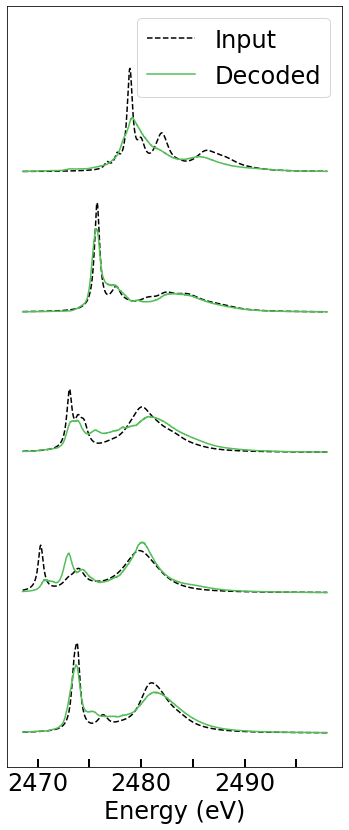

In [35]:
plot_in_v_out(XANESenergy, vae, x_decode, decode_names, figsize=(6,14), c=3, x_range=(50,-1), method='XANES')

In [36]:
PROPERTIES = ['oxy', 'Type', 'category']
Labels = []
for PROPERTY in PROPERTIES:
    Labels.append(get_Property(Data, PROPERTY))

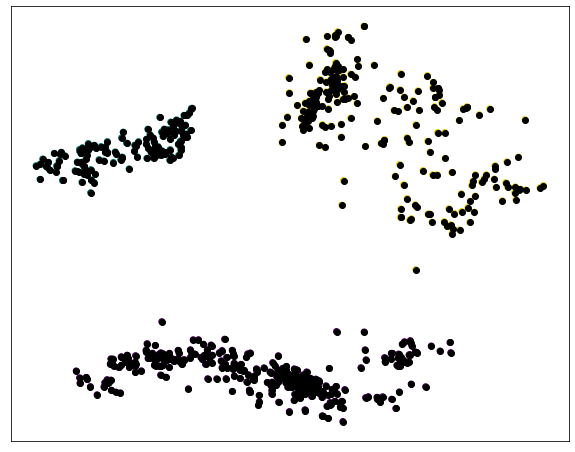

In [37]:
plot(Data, PROPERTIES[0], X, Labels[0], encoder, X, black=True)

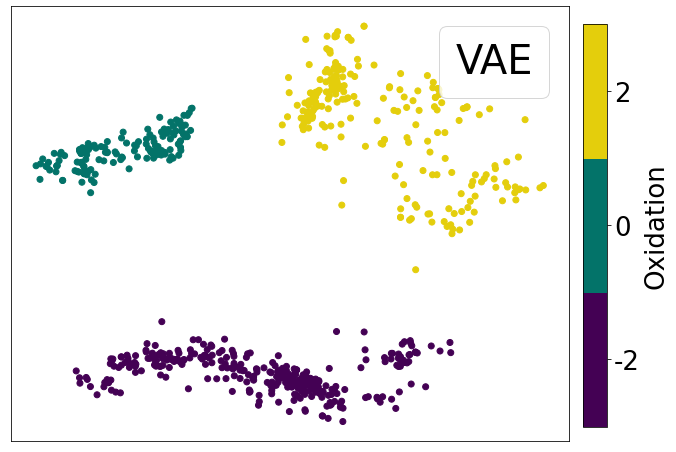

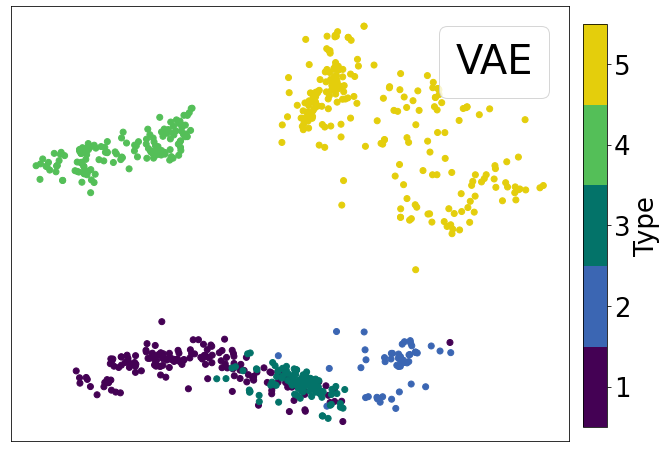

In [38]:
for PROPERTY in PROPERTIES[:2]:
    plot(Data, PROPERTY, X, Labels[PROPERTIES.index(PROPERTY)], encoder, X)

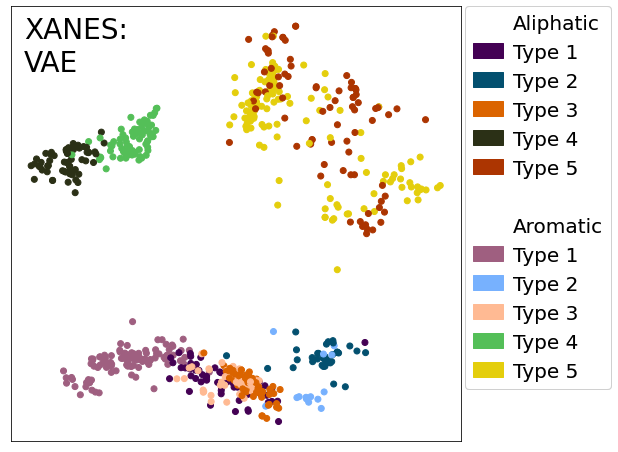

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot(Data, 'category', X, Labels[2], encoder, X, mode='XANES')

In [40]:
def get_type_eles(Data, t):
    temp = []
    for ele in Data:
        if ele['Type'] == t:
            temp.append(ele)
    return temp

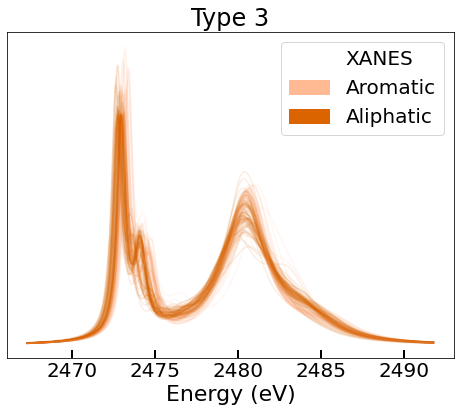

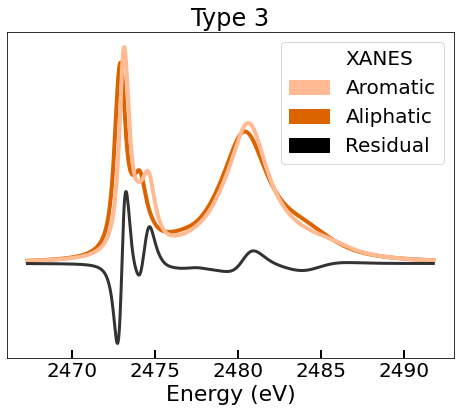

In [41]:
type_spagetti(XANESenergy, NAMES, Data, 'XANES', X, Type=3, space=0., figsize=(8,6), alpha=0.1) 

### K means

In [42]:
def plot_centroids(x_predict, y_predict, codebook):
    
    z_mean = encoder.predict(x_predict, batch_size=batch_size)[0]
    
    fontsize=16
    fig, ax = plt.subplots(figsize=(12, 8))
    if PROPERTY == 'oxy':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict)*2-4, cmap=COLORMAP)
        plt.colorbar(ticks=Oxys)
        plt.title("Latent Space vs Sulfur Oxidation", fontsize=fontsize+4)
    elif PROPERTY == 'category':
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=COLORMAP)
        plt.colorbar()
        plt.title("Latent Space vs Category", fontsize=fontsize+4)
    else:
        Colors = COLORS
        cmap = ListedColormap(Colors)
        plt.scatter(z_mean[:, 0], z_mean[:, 1], c=one_hot_to_num(y_predict), cmap=cmap)
        cbar = plt.colorbar(ticks=Types)
#         plt.title("Latent Space vs Type", fontsize=fontsize+4)
    
    plt.plot(codebook[:, 0], codebook[:, 1], '.', c='r', markersize=20)
    
    cbar.set_label(PROPERTY, fontsize=26)
    cbar.ax.tick_params(labelsize=22)
    
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    plt.show()

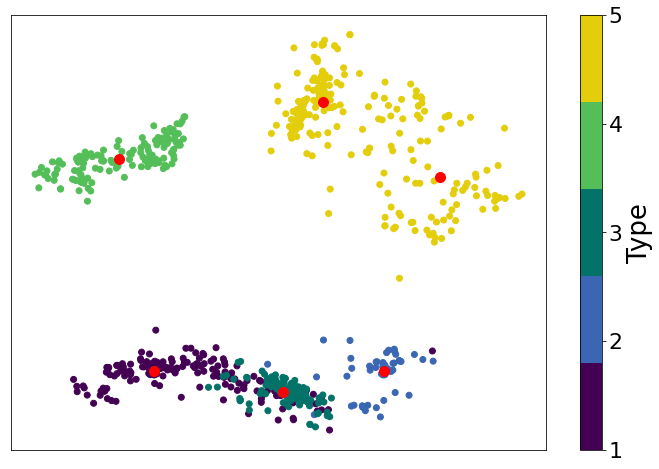

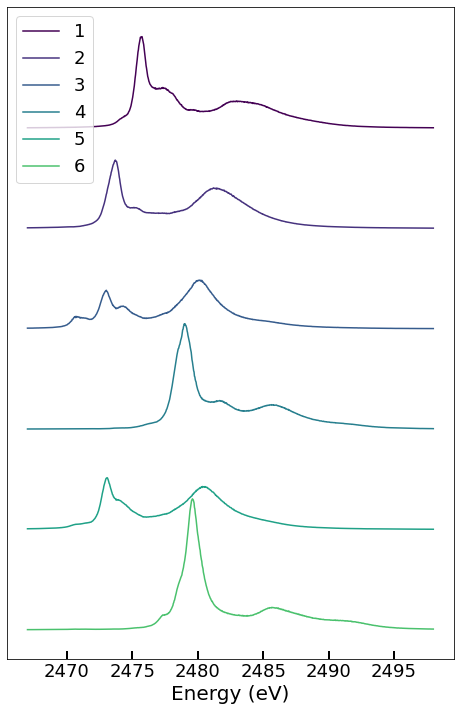

In [43]:
PROPERTY = 'Type'
z_mean = encoder.predict(X)[0]
codebook, distortion = kmeans(z_mean, 6)
plot_centroids(X, Labels[PROPERTIES.index(PROPERTY)], codebook)
Spectra = decoder.predict(codebook)
stack_plot(XANESenergy, Spectra, np.arange(len(codebook))+1, title=f'', space=0.5, figsize=(8,12))

# Principal Component Analysis (PCA)

In [44]:
pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)

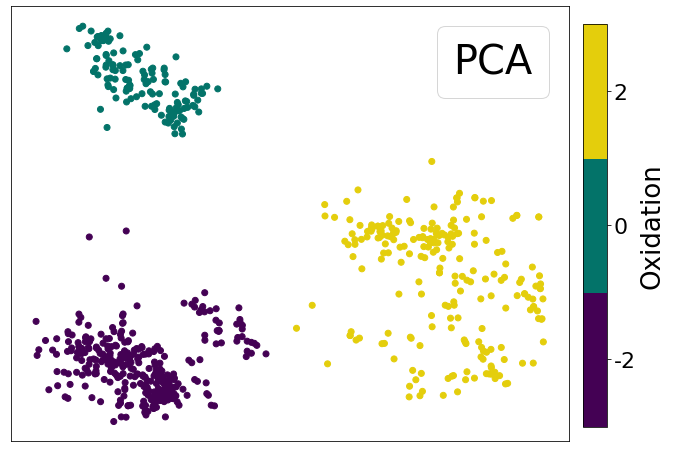

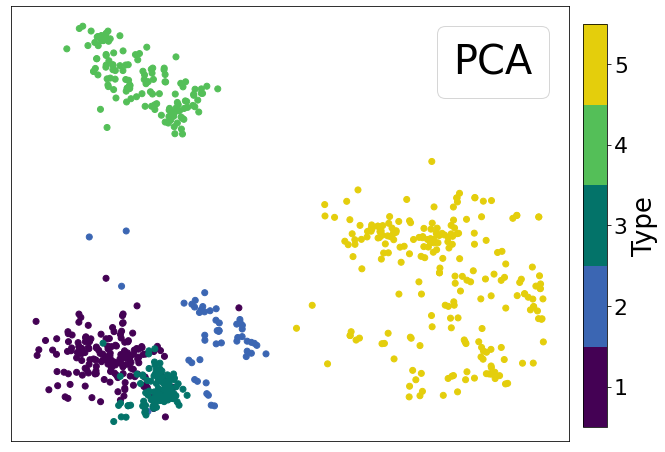

In [45]:
for PROPERTY in PROPERTIES[:2]:
    plot_dim_red(PROPERTY, X_PCA, Labels[PROPERTIES.index(PROPERTY)],'PCA', mode='XANES')

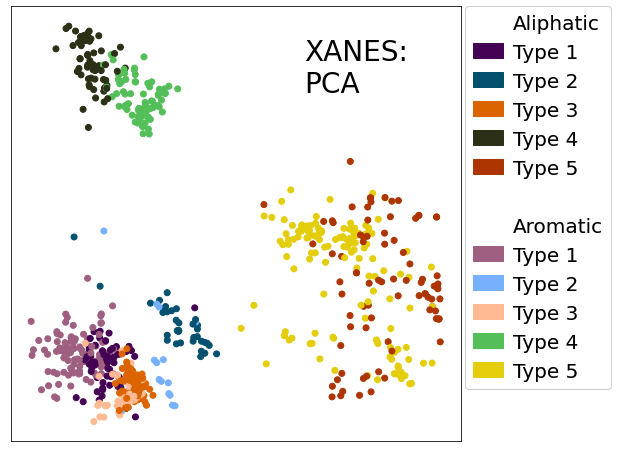

In [46]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('category', X_PCA, Labels[2],'PCA', mode='XANES')

In [47]:
def make_scree(evals, n):

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(n)+1
    colors = plt.cm.viridis(np.arange(N)/N)

    avg = np.zeros(n)
    for i in range(N):
        y = evals[i]
        y = y/np.sum(y)
        avg += y
    
    avg = avg/N
    ax.plot(x, avg, markersize=1, color='k', label='Average')

    plt.title("Scree Plot: XANES", fontsize=20)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component', fontsize=16)
    plt.ylabel(f'Propertion of Variance Explained', fontsize=16)
    
    plt.legend()

    plt.show()
    
    return avg

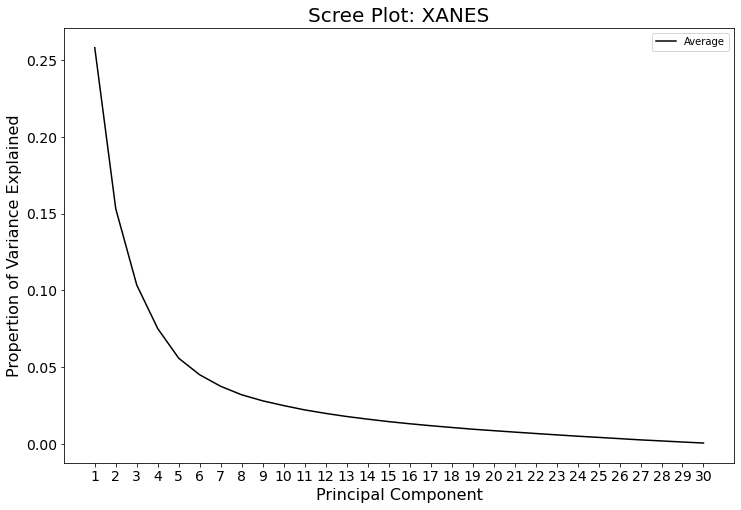

In [48]:
n = 30
pca = PCA(n_components=n)
pca.fit(X)
X_PCA = pca.transform(X)
evals = np.sort(np.abs(X_PCA), axis=1)
evals = np.flip(evals, axis=1)[:,:n]
xanes_pc = make_scree(evals, n)

In [49]:
xes_pc = np.array(['0.2099057', '0.1261262', '0.0936162', '0.0747139', '0.0609194',
       '0.0498248', '0.0430906', '0.0367303', '0.0319890', '0.0283283',
       '0.0251460', '0.0222887', '0.0200581', '0.0183026', '0.0167693',
       '0.0153394', '0.0140804', '0.0129600', '0.0119433', '0.0110746',
       '0.0103112', '0.0095227', '0.0088531', '0.0082462', '0.0077337',
       '0.0072569', '0.0068053', '0.0063984', '0.0060134', '0.0056523'], dtype=float)

In [50]:
def make_stacked_scree(xes, xanes, n=None):
    
    if n is None:
        n = len(xanes)
    else:
        xes = xes[:n]
        xanes = xanes[:n]

    fig, ax = plt.subplots(figsize=(10, 8))

    x = np.arange(n)+1

    ax.plot(x, xes, 's-', markersize=10, fillstyle='none', color=COLORS[1], label='VtC-XES')
    ax.plot(x, xanes, 'o-', markersize=10, color=COLORS[3], label='XANES')
    

    plt.xticks(x, fontsize=22)
    plt.yticks(fontsize=22)
    plt.xlabel('Number of Parameters', fontsize=24)
    plt.ylabel(f'Fraction of Contribution\n(Averaged Over Data)', fontsize=24)
    plt.xlim(0,n+1)
    ax.tick_params(direction='in', width=2, length=8)
    
    plt.legend(fontsize=26)

    plt.show()

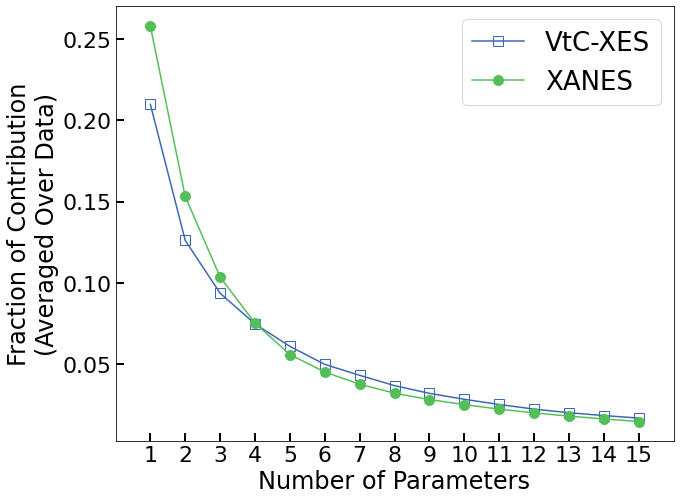

In [51]:
make_stacked_scree(xes_pc, xanes_pc, n=15)

1,3-Thiazol-4-ylacetic_acid


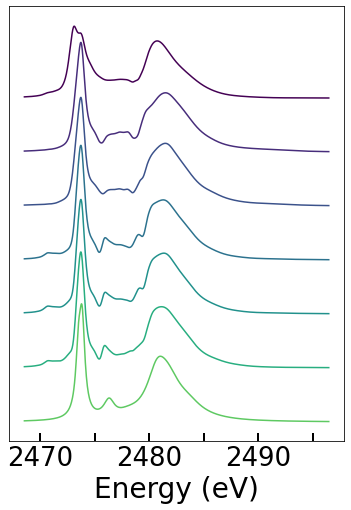

1,3-thiazolidin-2-one-sulfone


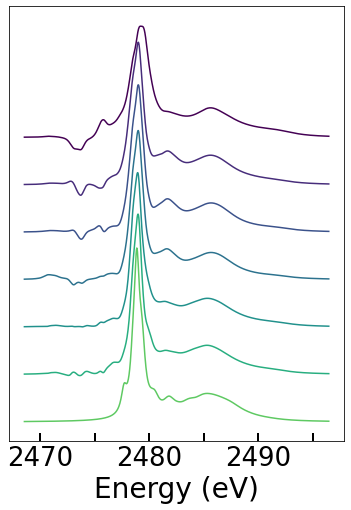

In [52]:
for i in [0, 498]:
    Recon = []
    Names = []

    s, e = 50,-50

    for nc in [2,4,6,8,10,12]:
        pca = PCA(n_components=nc)
        pca.fit(X)
        X_PCA = pca.transform(X)
        recon = pca.inverse_transform(X_PCA)
        Recon.append(recon[i].copy()[s:e])
        Names.append(f"{nc} PCs")

    x = X[i]
    name = Data[i]['name']
    print(name)

    Recon.append(x[s:e])
    Names.append('Target')
    stack_plot(XANESenergy[s:e], Recon, Names, '', space=0.2, figsize=(6,8),
               fontsize=24, leg=0, ncol=1, method='XANES')

# Other dimension Reduction!!!

In [53]:
fastICA = FastICA(n_components=2)
fastICA.fit(X)
X_FastICA = fastICA.transform(X)
TEST_X_FastICA = fastICA.transform(TEST_XANES)

fa = FactorAnalysis(n_components=2)
fa.fit(X)
X_FA = fa.transform(X)
TEST_X_FA = fa.transform(TEST_XANES)

nmf = NMF(n_components=2)
nmf.fit(X)
X_NMF = nmf.transform(X)
TEST_X_NMF = nmf.transform(TEST_XANES)

pca = PCA(n_components=2)
pca.fit(X)
X_PCA = pca.transform(X)
TEST_X_PCA = pca.transform(TEST_XANES)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XANES, batch_size=5)[0]

tsne = TSNE(n_components=2, perplexity=18, random_state=30)
X_TSNE = tsne.fit_transform(X)

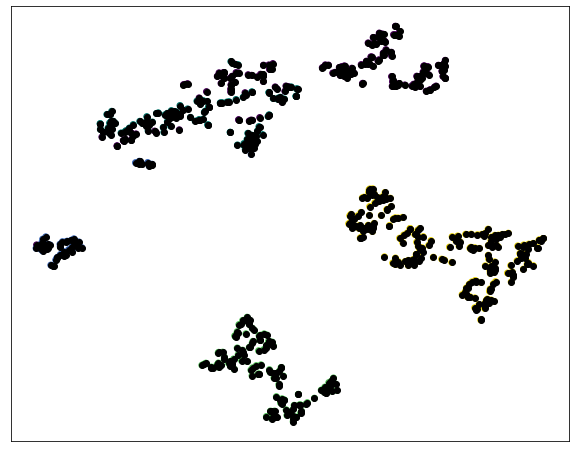

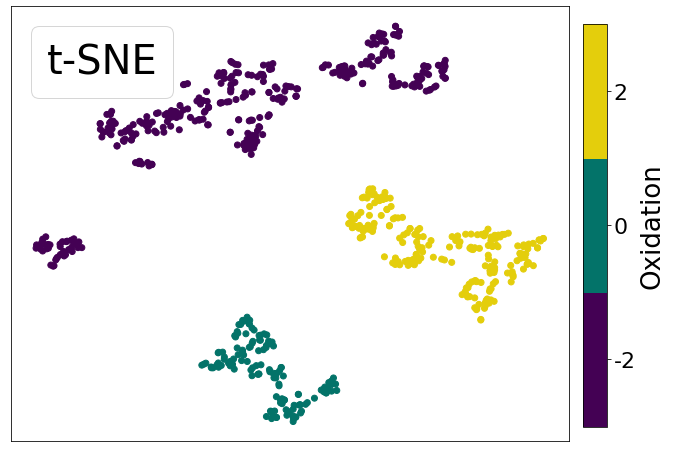

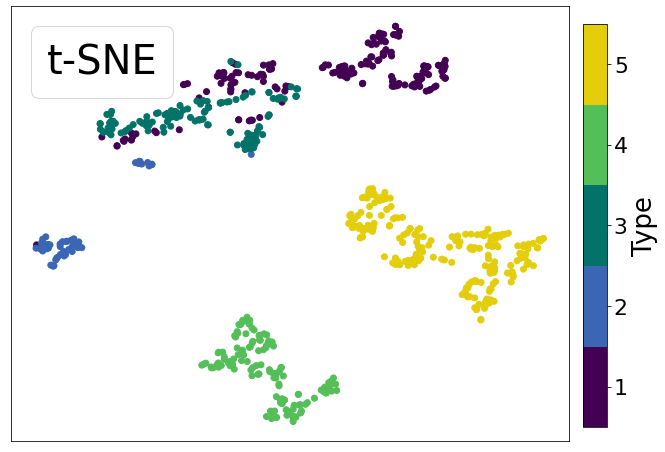

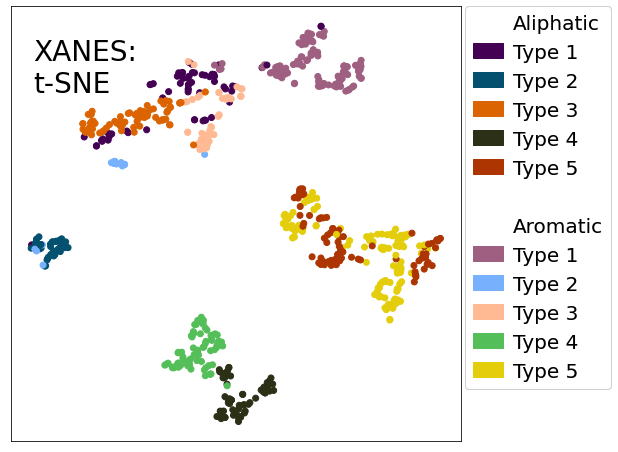

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE', black=True)
    plot_dim_red('oxy', X_TSNE, Labels[0],'t-SNE')
    plot_dim_red('Type', X_TSNE, Labels[1],'t-SNE')
    plot_dim_red('category', X_TSNE, Labels[2],'t-SNE', mode='XANES', xloc=0.05)

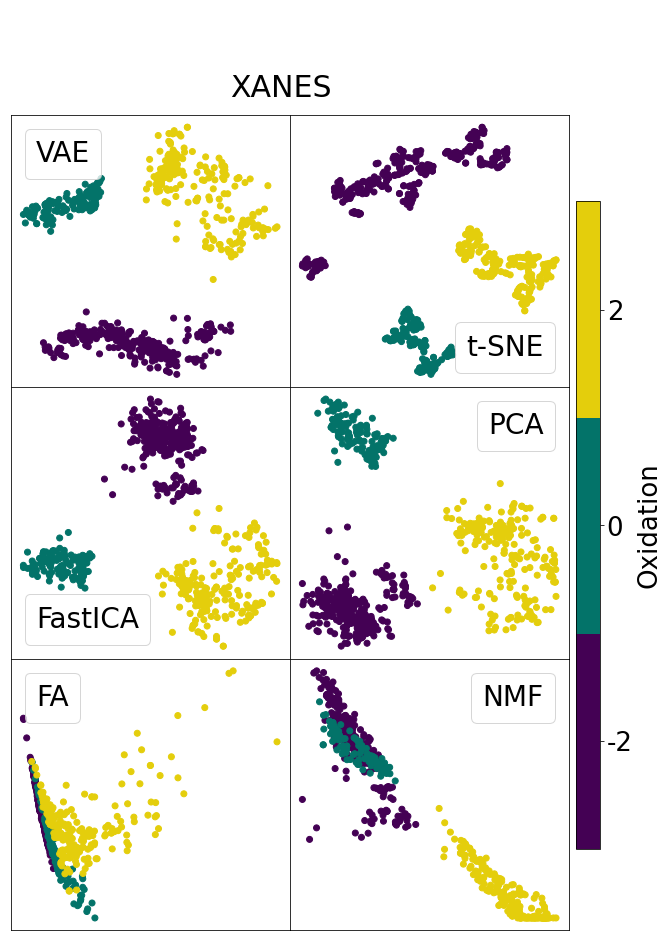

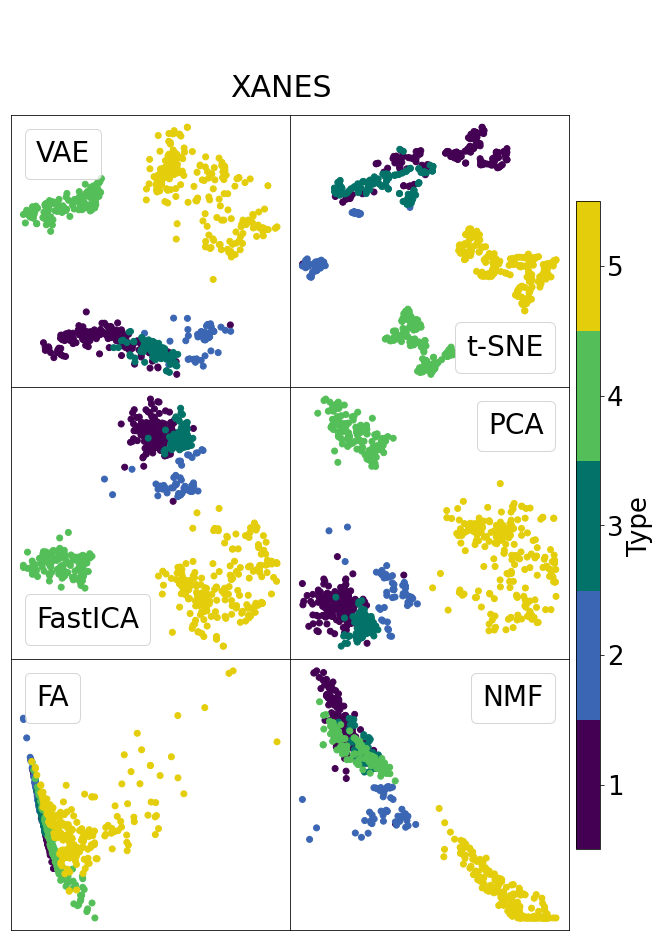

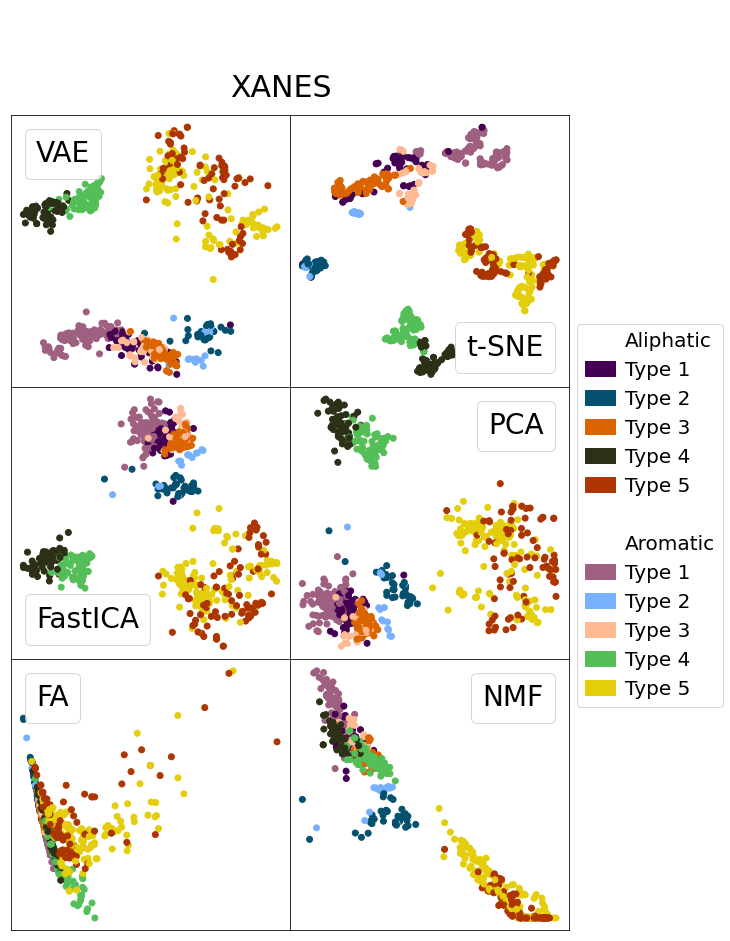

In [55]:
plot_dim_red_stack('oxy', [z_mean, X_TSNE, X_FastICA, X_PCA, X_FA, X_NMF],
                   Labels[0], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], mode='XANES')

plot_dim_red_stack('Type', [z_mean, X_TSNE, X_FastICA, X_PCA, X_FA, X_NMF],
                   Labels[1], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], mode='XANES')

plot_dim_red_stack('category', [z_mean, X_TSNE, X_FastICA, X_PCA, X_FA, X_NMF],
                   Labels[2], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], mode='XANES')

## Analysis of t-SNE

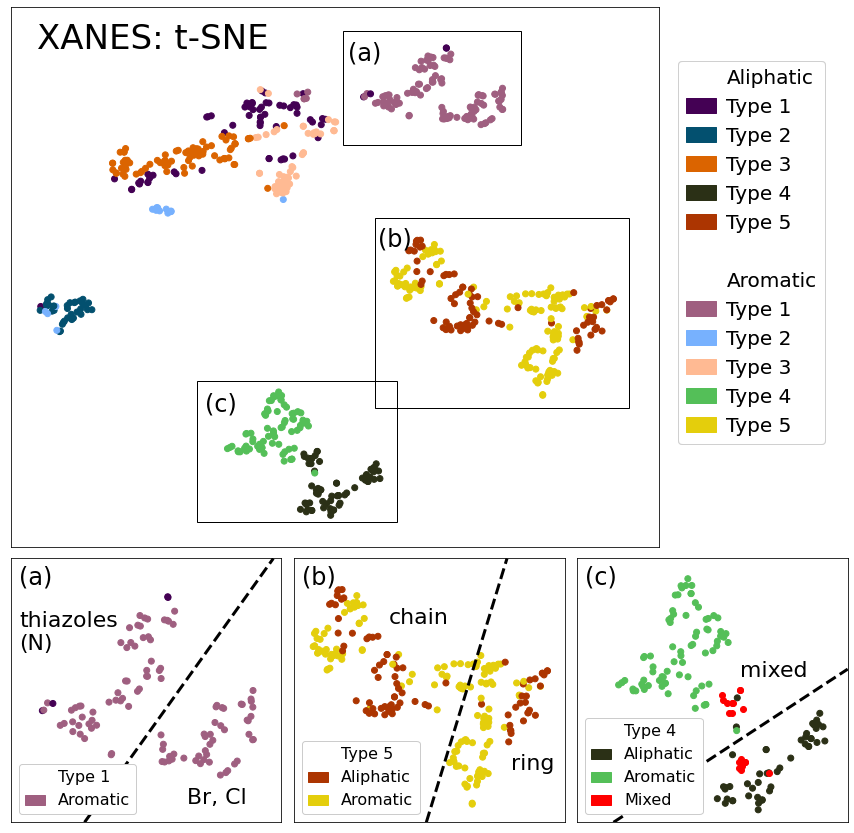

In [56]:
def cluster_ana(X_red, Y, method, Indices=None, Special_labels=None):
    
    Colors = list(COLORMAP(np.arange(1,11)/9))
    mode='XANES'
    fontsize=24
            
    # type 1
    Colors[0] = COLORS[0].copy()
    Colors[1] = '#9F5F80'
    # type 2
    Colors[2] = '#03506F'
    Colors[3] = COLORS[1].copy() + (60/255,75/255,75/255,0.)
    # type 3
    Colors[4] = '#DB6400'
    Colors[5] = '#ffba93'
    # type 4
    Colors[6] = '#2b3016' 
    Colors[7] = COLORS[3].copy()
    # type 5
    Colors[8] = '#ac3501'
    Colors[9] = COLORS[4]

    fig = plt.figure(figsize=(15,15))
    grid = plt.GridSpec(9, 9, wspace=0.15, hspace=0.15)
    
    bigax = plt.subplot(grid[:6, :7])
    ax1 =  plt.subplot(grid[6:, :3])
    ax2 =  plt.subplot(grid[6:, 3:6])
    ax3 =  plt.subplot(grid[6:, 6:])
    axes = [ax1, ax2, ax3]
    
    labels = ['a', 'b', 'c']
        
    Y = one_hot_to_num(Y)
    cmap = ListedColormap(Colors)
    
    Xlims = [(-1, 32), (5, 52), (-28, 9)]
    Ylims = [(25, 50), (-33, 9), (-58,-27)]
    Alphas = [1., 1., 1.]
    
    # type 1
    t1 = mpatches.Patch(color='w', label='Type 1')
    t1aro = mpatches.Patch(color=Colors[1], label='Aromatic')
    
    # type 4
    scolor = '#ff0000'
    t4 = mpatches.Patch(color='w', label='Type 4')
    t4ali = mpatches.Patch(color=Colors[6], label='Aliphatic')
    t4aro = mpatches.Patch(color=Colors[7], label='Aromatic')
    t4mix = mpatches.Patch(color=scolor, label='Mixed')
    
    # type 5
    t5 = mpatches.Patch(color='w', label='Type 5')
    t5ali = mpatches.Patch(color=Colors[8], label='Aliphatic')
    t5aro = mpatches.Patch(color=Colors[9], label='Aromatic')
    
    Handles = [[t1, t1aro], [t5, t5ali, t5aro], [t4, t4ali, t4aro, t4mix]]
    
    for i, ax in enumerate(axes):
        
        ax.set_xlim(Xlims[i])
        ax.set_ylim(Ylims[i])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        if i == 2:
            # plotting normal
            other_indices = list(set(np.arange(len(X_red))) - set(Indices))
            superset = X_red[other_indices]
            ax.scatter(superset[:, 0], superset[:, 1], c=Y[other_indices], cmap=cmap, alpha=Alphas[i])
            
            circle = plt.Circle((-5.2, -48), 6.8, lw=3, color='#000000',
                                 linestyle='--', fill=False)            
            # plotting mixed
            subset = X_red[Indices]
            ax.scatter(subset[:,0], subset[:,1], color=scolor)
                
            xs = np.linspace(Xlims[i][0] + 5, Xlims[i][1], 10)
            ys = np.linspace(Ylims[i][0], Ylims[i][1] - 13, 10)
            
            xy = (0.6, 0.55)
            ax.annotate('mixed',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
        elif i == 0:
            ax.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap, alpha=Alphas[i])
            xs = np.linspace(Xlims[i][0] + 9, Xlims[i][1] - 1, 10)
            ys = np.linspace(Ylims[i][0], Ylims[i][1], 10)
            
            xy = (0.032, 0.65)
            ax.annotate('thiazoles\n(N)',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
            xy = (0.65, 0.07)
            ax.annotate('Br, Cl',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
        elif i == 1:
            ax.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap, alpha=Alphas[i])
            xs = np.linspace(Xlims[i][0] + 23, Xlims[i][1] - 10, 10)
            ys = np.linspace(Ylims[i][0], Ylims[i][1], 10)
            
            xy = (0.35, 0.75)
            ax.annotate('chain',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
            
            xy = (0.8, 0.2)
            ax.annotate('ring',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize-2)
        

        # for all plots
        ax.plot(xs, ys, c='k', linestyle='--', linewidth=3)
        # annotation
        xy = (0.03, 0.9)  
        ax.annotate(f'({labels[i]})',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize)
        # legend
        leg = ax.legend(handles=Handles[i], loc=3, framealpha=1.,
                        fontsize=fontsize-8, handletextpad=0.05)
        for patch in leg.get_patches():
            patch.set_height(10)
            patch.set_width(20)

    
    bigax.axes.xaxis.set_visible(False)
    bigax.axes.yaxis.set_visible(False)
    
    bigax.scatter(X_red[:, 0], X_red[:, 1], c=Y, cmap=cmap)
    
    XYs = [(0.52, 0.9), (0.565, 0.555), (0.3, 0.25)]

    for i in range(3):
        xlim = Xlims[i]
        ylim = Ylims[i]
        width = xlim[1] - xlim[0]
        height = ylim[1] - ylim[0]
        box = plt.Rectangle((xlim[0], ylim[0]), width, height, lw=1, color='#000000',
                            linestyle='-', fill=False)
        bigax.add_patch(box)
        
        xy = XYs[i]  
        bigax.annotate(f'({labels[i]})',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize)
    xy = 0.04, 0.92
    bigax.annotate(f'{mode}: {method}',
                    xy=xy, xytext=xy,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    size=fontsize + 10)    
        
    t1a = mpatches.Patch(color=Colors[0], label='Type 1')
    t1b = mpatches.Patch(color=Colors[1], label='Type 1')
    t2a = mpatches.Patch(color=Colors[2], label='Type 2')
    t2b = mpatches.Patch(color=Colors[3], label='Type 2')
    t3a = mpatches.Patch(color=Colors[4], label='Type 3')
    t3b = mpatches.Patch(color=Colors[5], label='Type 3')
    t4a = mpatches.Patch(color=Colors[6], label='Type 4')
    t4b = mpatches.Patch(color=Colors[7], label='Type 4')
    t5a = mpatches.Patch(color=Colors[8], label='Type 5')
    t5b = mpatches.Patch(color=Colors[9], label='Type 5')
    space = mpatches.Patch(color='w', label='')
    aro = mpatches.Patch(color='w', label='Aromatic')
    ali = mpatches.Patch(color='w', label='Aliphatic')
            
    handles = [ali, t1a,t2a, t3a, t4a, t5a, space, aro, t1b, t2b, t3b, t4b, t5b]
    big_legend = bigax.legend(handles=handles, ncol=1, fontsize=20, handletextpad=0.001,
                              bbox_to_anchor=(1.03, 0.9), loc=2, borderaxespad=0.)
    bigax.add_artist(big_legend)
    for patch in big_legend.get_patches():
        patch.set_height(15)
        patch.set_width(30)

###################################################################################

# ax 1 focus
type4_special_indices = []
for i, ele in enumerate(Data):
    if ele['Mixed'] == 1: 
        type4_special_indices.append(i)
type4_special_indices = np.array(type4_special_indices)

cluster_ana(X_TSNE, Labels[2], 't-SNE', Indices=type4_special_indices)

### Panel a analysis

61
46


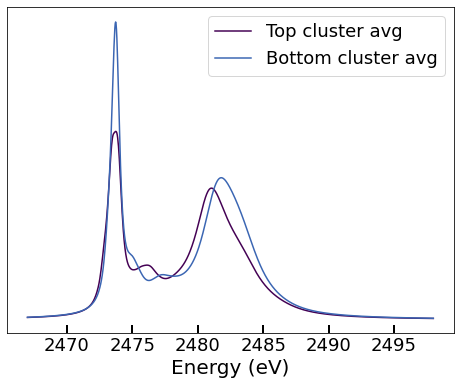

In [57]:
I = []
names1 = []
for i, ele in enumerate(Data):
    if ele['category'] == 2: 
        x, y = X_TSNE[i]
        if not ((x > 12 and y < 35) or x > 22):
            I.append(i)
            names1.append(NAMES[i])
I = np.array(I) 
print(len(I))
cluster1 = [get_x(name) for name in names1]
cluster1 = np.average(cluster1, axis=0)

I = []
names2 = []
for i, ele in enumerate(Data):
    if ele['category'] == 2: 
        x, y = X_TSNE[i]
        if (x > 12 and y < 35) or x > 22:
            I.append(i)
            names2.append(NAMES[i])
I = np.array(I) 
print(len(I))
cluster2 = [get_x(name) for name in names2]
cluster2 = np.average(cluster2, axis=0)

stack_plot(XANESenergy, [cluster1, cluster2], ['Top cluster avg', 'Bottom cluster avg'], '',
           space=0., figsize=(8,6), leg=1)

### Panel b analysis

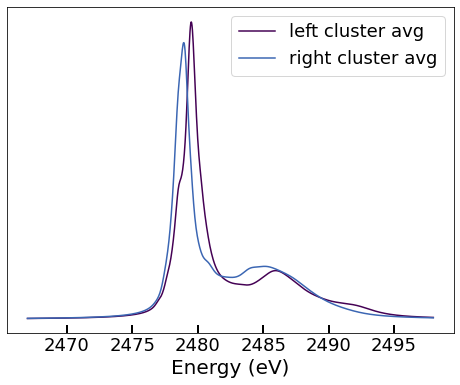

0.5585585585586159


0.25925925925925924

In [58]:
names_left = []
names_right = []
for i, ele in enumerate(Data):
    if ele['category'] == 9: 
        x, y = X_TSNE[i]
        if x < 35:
            names_left.append(NAMES[i])
        else:
            names_right.append(NAMES[i])

cluster1 = [get_x(name) for name in names_left]
cluster1 = np.average(cluster1, axis=0)

cluster2 = [get_x(name) for name in names_right]
cluster2 = np.average(cluster2, axis=0)

stack_plot(XANESenergy, [cluster1, cluster2], ['left cluster avg', 'right cluster avg'], '',
           space=0., figsize=(8,6), leg=1)

# energy shift
print(XANESenergy[np.argmax(cluster1)] - XANESenergy[np.argmax(cluster2)])

nonring = ['Butylate-sulfone', 'EPTC-sulfone', 'Methyl_Thiocyanate-sulfone', 'Molinate-sulfone',
           'Pebulate-sulfone', 'S-Benzylthiourea-sulfone', 'Triallate-sulfone']
len(nonring)/len(names_right)

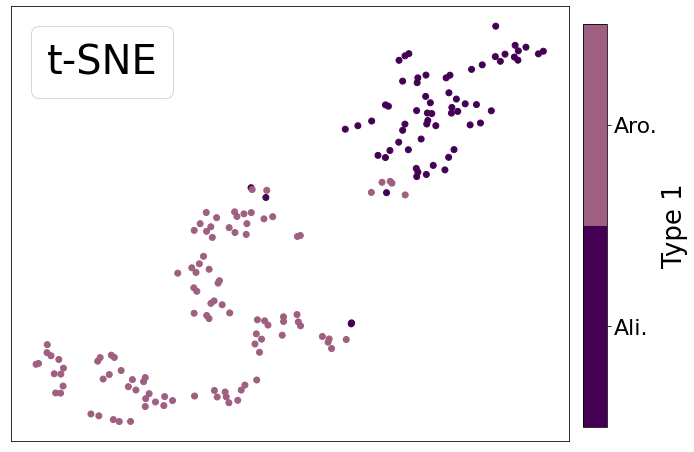

In [59]:
# 'Aliphatic' vs 'Aromatic' per type t-SNE
warnings.filterwarnings("ignore")

select_type = 1
x_one = []
y_one = []
names_one = []
for ele in Data:
    if ele['Type'] == select_type:
        x = ele['XANES'][1]
        x = x/SCALING_FACTOR
        x_one.append(x)
        y = ele['conj']
        y_one.append(y)
        names_one.append(ele['name'])

x_one = np.array(x_one)
y_one = np.array(y_one)

tsne = TSNE(n_components=2, perplexity=15, random_state=30)
X_TSNE_one = tsne.fit_transform(x_one)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_dim_red(select_type, X_TSNE_one, y_one,'t-SNE')

In [60]:
tsne = TSNE(n_components=2, perplexity=18, random_state=30)
everything = list(X)
for x in TEST_XANES:
    everything.append(x)
everything = np.array(everything)
X_TSNE = tsne.fit_transform(everything)
TEST_SIZE = len(TEST_XANES)

In [61]:
fastICA = FastICA(n_components=2)

fa = FactorAnalysis(n_components=2)

nmf = NMF(n_components=2)

pca = PCA(n_components=2)

z_mean = encoder.predict(X)[0]
TEST_z_mean = encoder.predict(TEST_XANES)[0]

In [62]:
warnings.filterwarnings("ignore")

Acc = [[],[],[]]
print("Oxidation:")
neis = 20
i = 0
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis))
print("\nType:")
neis = 20
i = 1
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis))
print("\nAro:")
neis = 10
i = 2
Acc[i].append(100*KNN_2D(encoder, Labels[i], 'VAE', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(pca, Labels[i], 'PCA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fastICA, Labels[i],'FastICA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(fa, Labels[i],'FA', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_2D(nmf, Labels[i],'NMF', X, TEST_XANES, scheme=i+1, n_neighbors=neis))
Acc[i].append(100*KNN_tsne(X_TSNE, Labels[i], 't-SNE', TEST_SIZE, scheme=i+1, n_neighbors=neis))

Oxidation:
KNN on VAE: Oxidation (Accuracy: 1.00)
KNN on PCA: Oxidation (Accuracy: 1.00)
KNN on FastICA: Oxidation (Accuracy: 1.00)
KNN on FA: Oxidation (Accuracy: 0.92)
KNN on NMF: Oxidation (Accuracy: 0.90)
KNN on t-SNE: Oxidation (Accuracy: 1.00)

Type:
KNN on VAE: Type (Accuracy: 0.90)
KNN on PCA: Type (Accuracy: 0.90)
KNN on FastICA: Type (Accuracy: 0.90)
KNN on FA: Type (Accuracy: 0.71)
KNN on NMF: Type (Accuracy: 0.88)
KNN on t-SNE: Type (Accuracy: 0.92)

Aro:
KNN on VAE: Aromaticity (Accuracy: 0.75)
KNN on PCA: Aromaticity (Accuracy: 0.69)
KNN on FastICA: Aromaticity (Accuracy: 0.69)
KNN on FA: Aromaticity (Accuracy: 0.56)
KNN on NMF: Aromaticity (Accuracy: 0.67)
KNN on t-SNE: Aromaticity (Accuracy: 0.87)


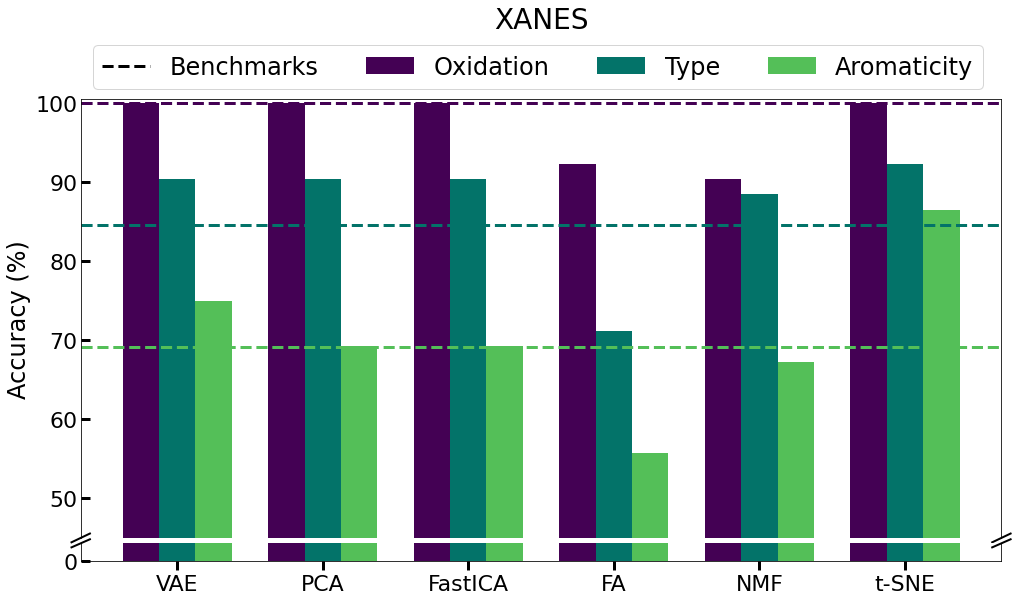

In [63]:
bar_chart(Acc, [100,84.6,69.2], mode='XANES')

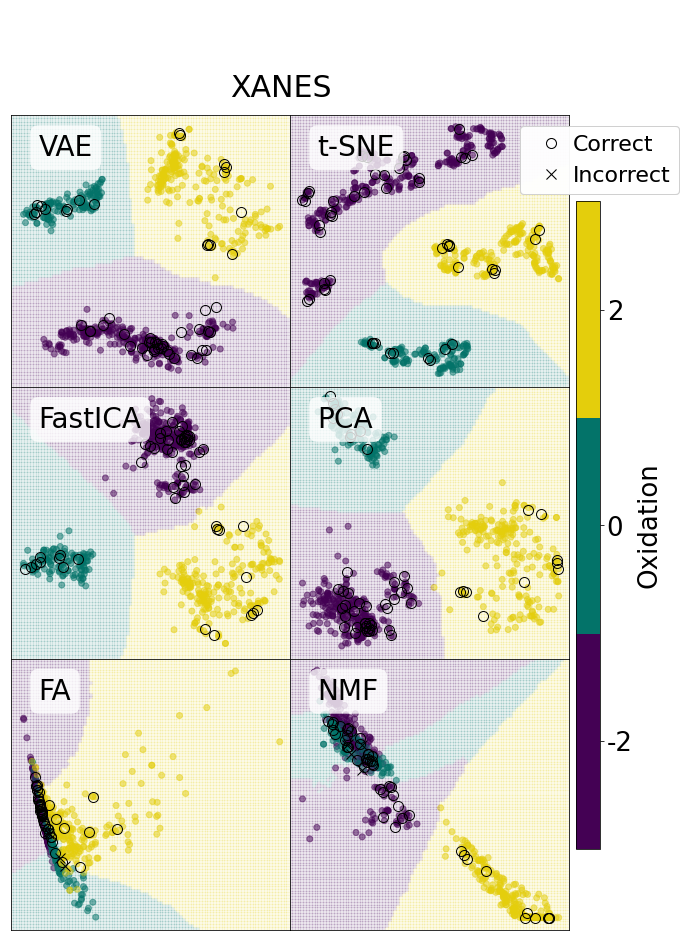

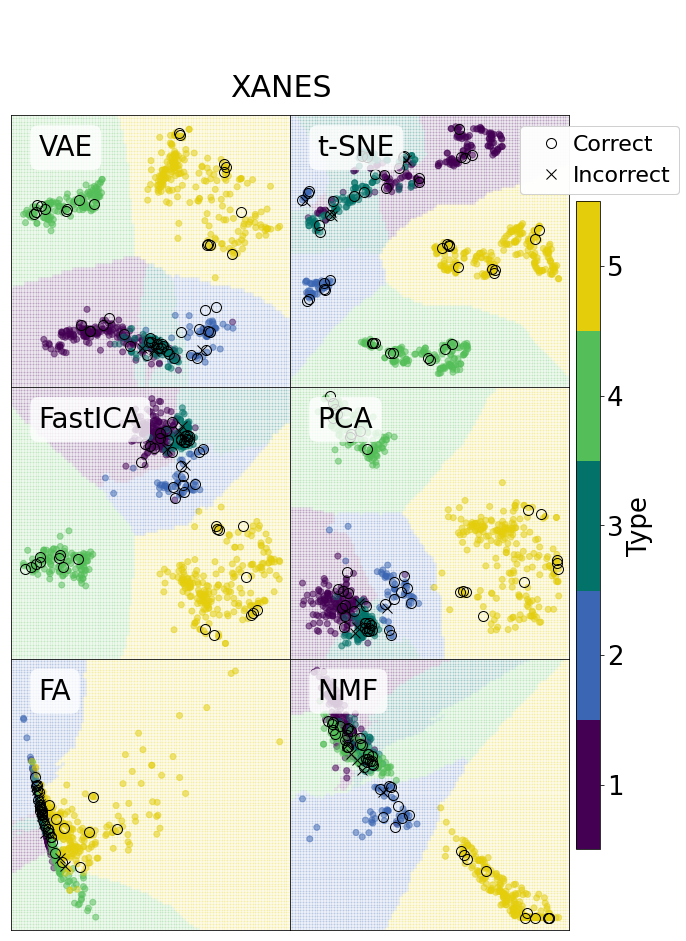

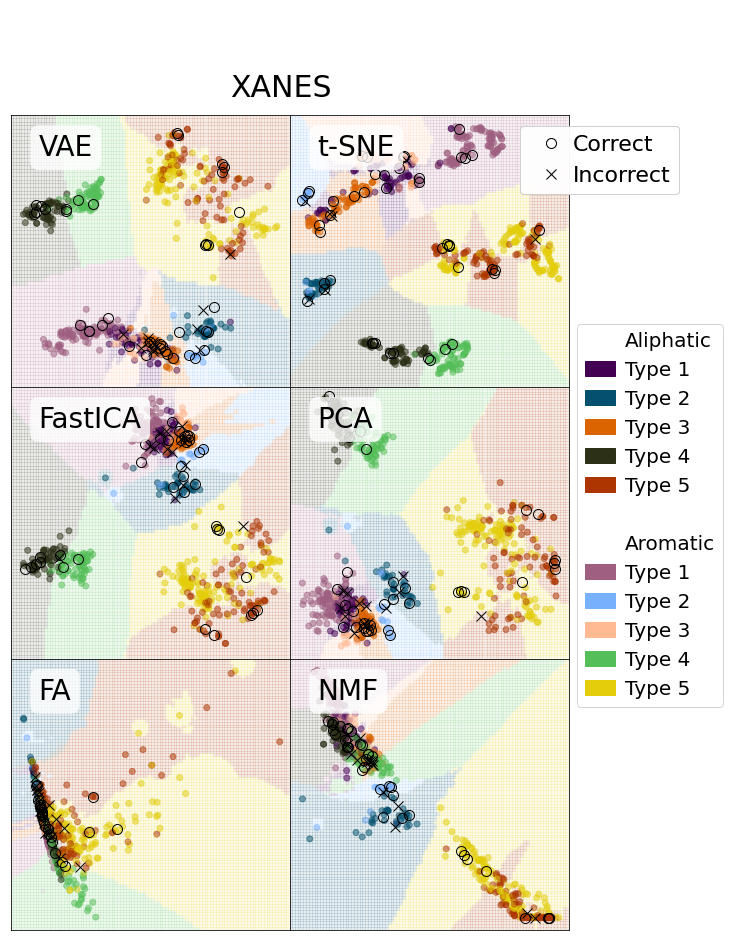

In [64]:
plot_KNN_stack('oxy', [z_mean, X_TSNE[:-TEST_SIZE,:], X_FastICA, X_PCA, X_FA, X_NMF],
               [TEST_z_mean, X_TSNE[-TEST_SIZE:,:], TEST_X_FastICA, TEST_X_PCA, TEST_X_FA, TEST_X_NMF],
               Labels[0], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], mode='XANES', n_neighbors=20)

plot_KNN_stack('Type', [z_mean, X_TSNE[:-TEST_SIZE,:], X_FastICA, X_PCA, X_FA, X_NMF],
               [TEST_z_mean, X_TSNE[-TEST_SIZE:,:], TEST_X_FastICA, TEST_X_PCA, TEST_X_FA, TEST_X_NMF],
               Labels[1], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], mode='XANES', n_neighbors=20)

plot_KNN_stack('category', [z_mean, X_TSNE[:-TEST_SIZE,:], X_FastICA, X_PCA, X_FA, X_NMF],
               [TEST_z_mean, X_TSNE[-TEST_SIZE:,:], TEST_X_FastICA, TEST_X_PCA, TEST_X_FA, TEST_X_NMF],
               Labels[2], ['VAE', 't-SNE', 'FastICA', 'PCA', 'FA', 'NMF'], mode='XANES', n_neighbors=10)